In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import qutip as qt 
from CD_control_optimization.batch_optimizer import BatchOptimizer
from CD_control_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from CD_control_optimization.optimization_sweeps import OptimizationSweeps
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Need tf version 2.3.0 or later. Using tensorflow version: 2.3.1



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 283863298378502918, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12902665224963421577
 physical_device_desc: "device: XLA_CPU device"]

In [2]:
#first, the optimization options.
N = 50 #hilbert space size
alpha_cat = 2 #desired cat alpha
params = {
'N_blocks' : 4, #number of blocks in circuit
'N_multistart' : 40, #number of optimizations to run in parallel
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.999, #terminal fidelitiy
'use_displacements' : False, #use D operators in optimization
'no_CD_end' : False, #set final CD = 0
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'alpha_scale' : 0.5, #maximum |alpha| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))],
'target_states' : [qt.tensor(qt.basis(2,1), (qt.coherent(N,alpha_cat) + qt.coherent(N,-alpha_cat)).unit())],
'name' : 'Cat creation', #name for printing and saving
'filename' : None, 
#if no filename specified, will be saved in this folder with default name #"name.h5" 
'alpha_cat' : alpha_cat, #note: can pass arbitrary parameters, will be saved
}


In [3]:
#create optimization object. 
#Note that initial params will be randomized upon creation
opt = BatchOptimizer(**params)

In [4]:
#print current info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 40
N_blocks: 4
term_fid: 0.999
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 0.5
use_displacements: False
name: Cat creation
comment: 
alpha_cat: 2
N_cav: 50
filename: Cat creation.h5

Best circuit parameters found:
betas:         [0.2733 -0.14177j 0.23512+0.63804j 2.3025 -0.25969j 1.32374-0.25463j]
alphas:        [0.+0.j]
phis (deg):    [  0.      114.85413 -36.63201 152.68741]
thetas (deg):  [ -57.06493 -145.38237 -143.53178 -171.63716]
Max Fidelity:  0.196768




In [5]:
#run optimizer.
opt.optimize()
#note that every time an optimizer is run, it will add to the same .h5 file in the filename, saving the data with a new timestamp

Start time: 2021-03-12 05:04:37
 Epoch: 71 / 200 Max Fid: 0.997302 Avg Fid: 0.793449 Max dFid: 0.000123 Avg dFid: 0.000005 Elapsed time: 0:02:42.308616 Remaing time: 0:04:54.898754

KeyboardInterrupt: 

In [6]:
#now, we can analyze the results.
#note that all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I would recommend using "HDFview" software to understand data structure
filename = opt.filename
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 4
N_cav: 50
N_multistart: 40
alpha_cat: 2
alpha_scale: 0.5
beta_scale: 3.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 162.30861639976501
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: Cat creation
no_CD_end: False
optimization_type: state transfer
term_fid: 0.999
termination_reason: outside termination
use_displacements: False
filename: Cat creation.h5

Best circuit parameters found:
betas:         [-3.96446+0.15689j -0.08893-0.39574j  0.33032-0.1085j   0.00004-0.j     ]
alphas:        [0.+0.j]
phis (deg):    [  0.       89.99655  89.99655 179.99622]
thetas (deg):  [ 89.99562 113.43847 -87.0028  -89.9958 ]
Max Fidelity:  0.997302




In [7]:
#saving the pulse for the experiment
bc = opt.best_circuit()
print(bc)
betas, alphas, phis, thetas = bc['betas'], bc['alphas'], bc['phis'], bc['thetas']
fname = r'Z:\Data\Tennessee2020\20201201_cooldown\conditional_displacement_circuits\20210312_cat_2.npz'
print(fname)
np.savez(fname, betas=betas, phis=phis, thetas=thetas)

{'fidelity': 0.9973019, 'betas': array([-3.9644434e+00+1.5726548e-01j, -8.8923596e-02-3.9569980e-01j,
        3.3025637e-01-1.0844153e-01j, -2.6296024e-05+1.9857391e-06j],
      dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       ,  1.5708368,  1.5708401, -3.1415522], dtype=float32), 'thetas': array([ 1.5708511,  1.979934 , -1.5184577, -1.5708443], dtype=float32)}
Z:\Data\Tennessee2020\20201201_cooldown\conditional_displacement_circuits\20210312_cat_2.npz


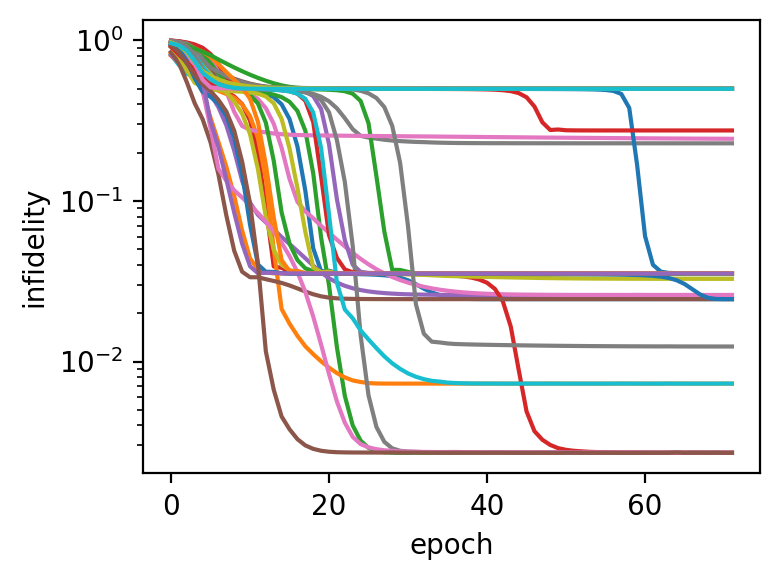

In [8]:
#We can plot the trajectories of the different parallel optimizations
analysis.plot_fidelities()

In [8]:
#We can also load the best circuit, states, and other parameters (see OptimizationAnalysis class)
best_circuit = analysis.best_circuit()
print(best_circuit)
target_state = analysis.target_state()
print(target_state)

{'fidelity': 0.99593514, 'betas': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64), 'alphas': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64), 'phis': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64), 'thetas': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64)}
Quantum object: dims = [[2, 50], [1, 1]], shape = (100, 1), type = ket
Qobj data =
[[ 1.16083086e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.46249408e-01+3.28332

In [ ]:
#Now, using the same opt object, we can sweep the number of blocks in the optimization.
sweeper = OptimizationSweeps(opt_object=opt)
sweeper.N_blocks_sweep(min_N_blocks=3, max_N_blocks=6, terminate=True) #"terminate" option specifies if it terminates sweep when term fid is met

In [ ]:
#the sweep data will be nicely saved to the same h5 file. We can analyze the sweep with the sweep analysis class.
sweep_analysis = OptimizationSweepsAnalysis(filename=filename)
sweep_analysis.sweep_names #names of the sweeps it found in the file

In [ ]:
#we can analyze how the best fidelity found depends on the sweep parameter
sweep_analysis.plot_sweep_fidelities(log=False)

In [ ]:
#there are a few other things we can plot. Better data analysis coming soon.
analysis.plot_mag_betas()

In [ ]:
analysis.plot_phase_betas()

In [ ]:
analysis.plot_mag_alphas()

In [ ]:
analysis.plot_phase_alphas()

In [ ]:
analysis.plot_average_magnitude_alpha()

In [ ]:
analysis.plot_average_magnitude_beta()

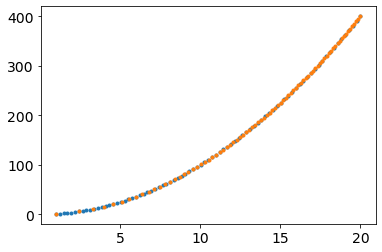

In [15]:
xs = np.linspace(1,20,81)
plt.plot(xs, xs**2, '.')
xs2 = np.sqrt(np.linspace(xs[0]**2, xs[-1]**2, len(xs)))
plt.plot(xs2, xs2**2, '.')